In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

## 读取数据集并标准化消除量纲

In [2]:
finaldata = pd.read_csv('finaldata.csv',encoding = 'gbk')
finalX = finaldata.iloc[:,1:21]
y = finaldata.iloc[:,-1]
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(finalX)

## 划分数据集

In [3]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(finalX,y,test_size=0.3,random_state=2018)

In [4]:
params_lr = {'solver': ['newton-cg', 'lbfgs', 'sag'], 'C': [0.1, 1, 10]}
lr_model = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), params_lr, cv=5, scoring='roc_auc')

params_svm = {'kernel': ('linear', 'rbf'), 'C': [0.1, 1, 10]}
svm_model = GridSearchCV(SVC(class_weight='balanced', gamma='auto', probability=True), params_svm, cv=5, scoring='roc_auc')

params_dt = {'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2', None]}
dt_model = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), params_dt, cv=5, scoring='roc_auc')

params_rf = {'n_estimators': range(10, 80, 10), 'criterion': ['gini', 'entropy'], 'max_features': ['sqrt', 'log2', None]}
rf_model = GridSearchCV(RandomForestClassifier(class_weight='balanced'), params_rf, cv=5, scoring='roc_auc')

params_en = {'n_estimators': range(10, 80, 10)}
gbdt_model = GridSearchCV(GradientBoostingClassifier(), params_en, cv=5, scoring='roc_auc')
xg_model = GridSearchCV(XGBClassifier(), params_en, cv=5, scoring='roc_auc')
lgb_model = GridSearchCV(lgb.LGBMClassifier(), params_en, cv=5, scoring='roc_auc')

models = {'LR': lr_model,
          'SVM': svm_model,
          'DT': dt_model,
          'RF': rf_model,
          'GBDT': gbdt_model,
          'XGBoost': xg_model,
          'LightGBM': lgb_model}

In [5]:
def get_metric(clf, X, y_true):
    y_pred = clf.predict(X)
    y_proba = clf.predict_proba(X)

    acc = metrics.accuracy_score(y_true, y_pred)
    p = metrics.precision_score(y_true, y_pred)
    r = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_proba[:, 1])
    auc = metrics.auc(fpr, tpr)
    return acc, p, r, f1, fpr, tpr, auc


def plot_roc(fprs, tprs, aucs, title):
    plt.figure()
    lw = 2
    for i, name in enumerate(models):
        plt.plot(fprs[i], tprs[i], lw=lw,
                 label='{0} (AUC:{1:0.2f})'.format(name, aucs[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of '+title)
    plt.legend(loc="lower right")
    plt.show()

LR
{'C': 0.1, 'solver': 'newton-cg'}


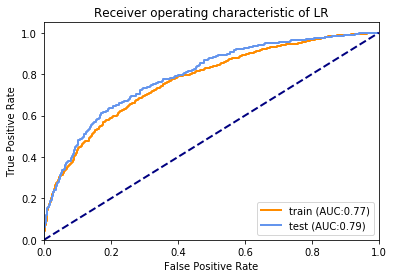

In [ ]:
df_result = pd.DataFrame(columns=('Model', 'dataset', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC'))
row = 0
fprs_train = []
tprs_train = []
aucs_train = []
fprs_test = []
tprs_test = []
aucs_test = []
for name, clf in models.items():
    clf.fit(Xtrain, Ytrain)
    print(name)
    print(clf.best_params_)
    acc, p, r, f1, fpr_train, tpr_train, auc_train = get_metric(clf, Xtrain, Ytrain)
    fprs_train.append(fpr_train)
    tprs_train.append(tpr_train)
    aucs_train.append(auc_train)
    df_result.loc[row] = [name, 'train', acc, p, r, f1, auc_train]
    row += 1

    acc, p, r, f1, fpr_test, tpr_test, auc_test = get_metric(clf, Xtest, Ytest)
    fprs_test.append(fpr_test)
    tprs_test.append(tpr_test)
    aucs_test.append(auc_test)
    df_result.loc[row] = [name, 'test', acc, p, r, f1, auc_test]
    row += 1

    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='darkorange', lw=lw, label='train (AUC:%0.2f)' % auc_train)
    plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=lw, label='test (AUC:%0.2f)' % auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of '+name)
    plt.legend(loc="lower right")
    plt.show()


print(df_result)

plot_roc(fprs_train, tprs_train, aucs_train, 'train')
plot_roc(fprs_test, tprs_test, aucs_test, 'test')

In [ ]:
df_result